## **Fraud Analytics Assignment 1- Computing Trust Rank**


# Team - Aditya Shinde **AI24MTECH11004**

# A. Problem Statement -Computing Trust Rank
To compute the TrustRank of users Using only Pregel Framework in a financial transaction network to identify fraudulent accounts.

Given Data:

**Payments.csv**: Contains financial transactions in the form:
Sender → Receiver with a transaction value.
**bad_sender.csv**: Contains a list of known fraudulent accounts.

# B. Description of the dataset

The dataset used in this study, named "Payments.csv" and "bad_sender.csv" file contains a list of 20 bad nodes, which are used as a seed set in the study.

**Dataset Details**

**1. Payments.csv (Transaction Graph)**
This file represents a directed graph, where:

Nodes: Users in the system.
Edges: Transactions between users.

The column names in the files are:

Payments.csv: Sender, Receiver, Amount.

bad_sender.csv: Bad Sender

Attributes:

Sender ID (src) → Seller node.

Receiver ID (dst) → Buyer node.\

Value (amount) → Importance of the transaction.

If multiple transactions exist between the same two users, their values are consolidated by summing up the amounts.



**Statistics**
The computed statistics for your dataset are:

Unique Nodes (N): 799
Nodes with No Outgoing Links (M): 96
Bad Nodes (F): 20

**2. bad_sender.csv (Fraudulent Accounts)**

Contains a list of 20 fraudulent user IDs.

These nodes will be used as a seed set for TrustRank computation.

**Statistics:**

Total Fraudulent Nodes: 20


# C. Solution Steps
 1. Loads the Data:

  Reads Payments.csv (Transaction Graph) with Sender → Receiver → Amount.
Reads bad_sender.csv (List of Fraudulent Accounts).

2. Constructs the Graph:

  Nodes = Unique users (sellers & buyers).
  Edges = Transactions between users, weighted by amount.
  Handles multiple transactions between the same two users by summing values.

3. Assigns Initial Trust Scores:

  Fraudulent users (from bad_sender.csv) get an initial score of 1.
  Others start with 0 trust.

4. Implements Pregel-Based TrustRank:

  Uses a multithreaded Pregel-like framework for distributed computation.
  Each vertex (user) independently updates its trust score based on incoming messages.
  Handles leakage by linking sink nodes (no out-links) back to bad nodes.

5. Computes TrustRank:

  Runs 100 iterations with a damping factor (0.85).
  Uses vertex-based parallel trust propagation (Pregel-style worker threads).
  Outputs final trust scores for all nodes.

6. Results & Visualization:

  Plots TrustRank distribution across users.
  Highlights bad nodes and their TrustRank evolution over iterations.
  Provides ranked list of high-risk users (higher TrustRank = more likely fraudulent).


# D. Algorithm Used

- TrustRank : TrustRank is a variation of PageRank (topic-specific PageRank) that introduces the notion of a set of trusted pages that act as seed nodes. The goal of TrustRank is to identify trustworthy pages on the web, and to demote spam pages, which link only to other spam pages. The idea is to start with a set of trusted seed nodes and iteratively propagate trust scores along the graph edges. In this work we leverage TrustRank to find bad nodes by using a set of oracle provided bad nodes as seed set. As a result, the resulting rank will be higher for bad nodes and lower for good nodes. Since we use bad nodes as the seed set, the computed ranks will be higher for bad nodes and lower for good nodes, effectively ranking nodes by their likelihood of being fraudulent.

  - Handling leakage : To prevent leakage, we redistribute the trust of sink nodes by linking them back to all bad nodes equally. This ensures that accumulated trust is propagated instead of being lost.


  - TrustRank Equation : T(v)=(1-d).S(v)+d.∑_u∈B(v) T(u)/∣B(u)∣
  
    where-

    -T(v) is the trust score of node v

    -d is the damping factor (default 0.85).

    -S(v) is 1 for bad nodes, 0 for others.

    -B(v) is the set of nodes linking to v

    -∣B(u)∣ is the out-degree of node u

- Pregel : It is a distributed-computing framework developed by Google. The main use case of it that, it can handle graphs with large number of nodes distributed across a cluster of computers. It is designed in such a way that each vertex operates independently while maintaining its state, receiving messages from its neighboring vertices, and updating its state accordingly. While the current scenario doesnt requires for such scalable framework, this demonstrates the efficay of it. It must be noted that while a full Pregel cluster is not necessary for this scenario, we simulate distributed behavior using multithreading, where each thread handles a subset of nodes.


- Hyperparameters :
  - `num_threads` : `4`
  - `damping_factor` : `0.85`
  - `iterations` : `100`



# Load Necessary Libraries

In [ ]:
from numpy import mat, eye, zeros, ones, linalg
import random
import pandas as pd
import numpy as np
from collections import defaultdict, OrderedDict

#  Load and Verify Data

In [ ]:
# check if the dataset exists
import os
assert os.path.isfile('/content/Payments.csv') and os.path.isfile('/content/bad_sender.csv'), "Payments.csv and bad_sender.csv files doesnt exist!"
import pandas as pd
pd.read_csv('/content/Payments.csv')

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396
...,...,...,...
130530,1344,1390,21739
130531,1914,1390,3374
130532,1914,1390,5186
130533,1914,1390,1559


### Support functions for Pregel Framework


In [ ]:
"""pregel.py is a python 2.6 module implementing a toy single-machine
version of Google's Pregel system for large-scale graph processing."""

import collections
import threading
import time

class Vertex():

    def __init__(self,id,value,out_vertices):
        # This is mostly self-explanatory, but has a few quirks:
        #
        # self.id is included mainly because it's described in the
        # Pregel paper.  It is used briefly in the pagerank example,
        # but not in any essential way, and I was tempted to omit it.
        #
        # Each vertex stores the current superstep number in
        # self.superstep.  It's arguably not wise to store many copies
        # of global state in instance variables, but Pregel's
        # synchronous nature lets us get away with it.
        self.id = id
        self.value = value
        self.out_vertices = out_vertices
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0

class Pregel():

    def __init__(self,vertices,num_workers):
        self.vertices = vertices
        self.num_workers = num_workers

    def run(self):
        """Runs the Pregel instance."""
        self.partition = self.partition_vertices()
        while self.check_active():
            self.superstep()
            self.redistribute_messages()

    # def partition_vertices(self):
    #     """Returns a dict with keys 0,...,self.num_workers-1
    #     representing the worker threads.  The corresponding values are
    #     lists of vertices assigned to that worker."""
    #     partition = collections.defaultdict(list)
    #     for vertex in self.vertices:

    #         partition[self.worker(vertex)].append(vertex)
    #     return partition

    def partition_vertices(self):
        """
        Modified by us.
        [x] there is a bug in the provided pregel code where all the vertices are run using a single worker
        irrespective of the number of workers. This is because of the way the workers are assigned. I have replaced the hash based one
        with equally distributing the vertex among the workers.

        Returns a dict with keys 0,...,self.num_workers-1
        representing the worker threads.  The corresponding values are
        lists of vertices assigned to that worker.
        """
        partition = collections.defaultdict(list)
        each = len(self.vertices) // self.num_workers

        for i in range(self.num_workers):
            partition[i] = self.vertices[i*each: (i+1)*each]

            if i == self.num_workers-1:
                partition[i] = self.vertices[i*each: ]

        return partition

    # def worker(self,vertex):
    #     """Returns the id of the worker that vertex is assigned to."""
    #     return hash(vertex) % self.num_workers

    def superstep(self):
        """Completes a single superstep.

        Note that in this implementation, worker threads are spawned,
        and then destroyed during each superstep.  This creation and
        destruction causes some overhead, and it would be better to
        make the workers persistent, and to use a locking mechanism to
        synchronize.  The Pregel paper suggests that this is how
        Google's Pregel implementation works."""
        workers = []
        for vertex_list in self.partition.values():
            worker = Worker(vertex_list)
            workers.append(worker)
            #print(f" Worker started with vertices list : {[v.id for v in vertex_list]}")
            worker.start()
        for worker in workers:
            worker.join()

    def redistribute_messages(self):
        """Updates the message lists for all vertices."""
        for vertex in self.vertices:
            vertex.superstep +=1
            vertex.incoming_messages = []
        for vertex in self.vertices:
            for (receiving_vertix,message) in vertex.outgoing_messages:
                receiving_vertix.incoming_messages.append((vertex,message))

    def check_active(self):
        """Returns True if there are any active vertices, and False
        otherwise."""
        return any([vertex.active for vertex in self.vertices])

class Worker(threading.Thread):

    def __init__(self,vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        self.superstep()
        #time.sleep(10)
        #print(f" Worker completed superstep with vertices list : {[v.id for v in self.vertices]}")


    def superstep(self):
        """Completes a single superstep for all the vertices in
        self."""
        for vertex in self.vertices:
            if vertex.active:
                vertex.update() # main TrustRank computation is done here only





## Function descriptions

- `intialTrustRank` :  Initiallizes the initial ranking based on the bad nodes.
- `get_connections` : Get edges and creates graph. If there are no outgoing link, the messages will get accumulated at those nodes and cause leakage. This leakage is handled by creating synthetic outlink from these nodes to all the bad nodes with equal edge weights. This way the leaked values gets propagated back to the bad nodes equally.
- `PregelTrustRank` : Compute Pagerank using pregel by assigning set of vertices to thread.

- `TrustRankVertex` : Vertex class for TrustRank algorithm. Handles the propagation of trust across nodes. Outgoing messages earlier was divide equally by all outgoing links. Now it is instead multiplied by weightage of each link which is based on normed values of outgoing links.

# Initialize Trust Scores, Define Pregel Framework and Distributed Pregel Execution

In [ ]:
#Initialize Trust Score
def intialTrustRank(nodes, bad_nodes):
    """
    Initiallizes the initial ranking based on the bad nodes.
    """
    score = np.zeros(len(nodes))
    for i in bad_nodes:
        score[i] = 1/len(bad_nodes)
    return list(score)


def get_connections(edge_file, nodes_dict, nodes, bad_nodes):
    """
    get edges - if there are no outgoing link, point it to all the bad nodes with equal weightage - handles leakage
    """
    edges_mapped = defaultdict(list)
    edges = defaultdict(list)
    values = {}
    for i in range(len(edge_file)):
        from_, to_, value = int(edge_file.iloc[i][0]), int(edge_file.iloc[i][1]), int(edge_file.iloc[i][2])
        if to_ not in edges[from_]:
            edges[from_].append(to_)
            edges_mapped[nodes_dict.get(from_)].append(nodes_dict.get(to_))

        if len(values.get(nodes_dict.get(from_), [])) == 0:
            values[nodes_dict.get(from_)] = {}
            values[nodes_dict.get(from_)][nodes_dict.get(to_)] = 0

        values[nodes_dict.get(from_)][nodes_dict.get(to_)] = values[nodes_dict.get(from_)].get(nodes_dict.get(to_), 0) + value

    # handling leakage by connecting nodes back to the bad nodes with equal weigtage
    empty = list(set(nodes).difference(set(edges_mapped.keys())))
    for i in empty:
        edges_mapped[i] = edges_mapped.get(i, []) + bad_nodes
        values[i] = {}
        for j in bad_nodes:
          values[i][j] = 1

    return edges, edges_mapped, values, nodes

def PregelTrustRank(vertices):
    """
    Compute Pagerank using pregel by assing set of vertices to thread.

    [x] there is a bug in the provided pregel code where all the vertices are run using a single worker
    irrespective of the number of workers. This is because of the way the workers are assigned.
    """

    p = Pregel(vertices, num_workers=4)
    p.run()
    return mat([vertex.value for vertex in p.vertices]).transpose(), p

# Define Pregel Framework
class TrustRankVertex(Vertex):
    """
    Vertex class for TrustRank algorithm
    """
    def __init__(self,id,value,out_vertices, weightage_values, dampingFactor=0.85,iterations=50):
        Vertex.__init__(self,id,value,out_vertices)
        self.dampingFactor = dampingFactor
        self.num_supersteps = iterations
        self.weightage_values = weightage_values
        self.values_iterations = []
        self.d = value  # this d is same as the 1/d in the TrustRank equation. The division has already been done outside this function. So we now have to just multiply this d.
# Distributed Pregel Execution
    def update(self):
        """
        CHANGES MADE:
        [x] Leakage is handled by connecting nodes with no outlinks back to bad nodes with equal weights
        [x] Outgoing messages earlier was divide equally by all outgoing links. Now it is
        instead multiplied by weightage of each link which is based on normed values of outgoing links.
        """
        if self.superstep < self.num_supersteps:
            messages_sum = 0
            for (vertex,message) in self.incoming_messages:
                messages_sum = messages_sum+message
            self.value = self.dampingFactor*messages_sum +  (1-self.dampingFactor)*self.d   # this is the main equation of TrustRank (given in slides)
            outgoing_message_all = [self.value*weight for weight in self.weightage_values]   # outgoing message is divided based on the weightage of each link
            self.outgoing_messages = [(vertex,outgoing_message) for vertex, outgoing_message in zip(self.out_vertices, outgoing_message_all)]
            self.values_iterations.append(self.value)
        else:
            self.active = False

### 1. Load dataset

In [ ]:
df = pd.read_csv('/content/Payments.csv')

# load nodes
_bad_nodes = list(set(pd.read_csv('/content/bad_sender.csv')["Bad Sender"]))
_nodes  = list(set(list(set(df["Sender"])) + list(set(df["Receiver"])) ))

### 2. Map to change arbitary node name to begin from 0

In [ ]:
nodes_dict = dict(zip( _nodes, np.arange(len(_nodes))))

# mapping nodes
nodes = [nodes_dict.get(i) for i in _nodes]
bad_nodes = [nodes_dict.get(i) for i in _bad_nodes]

### 3. Get edges

In [ ]:
# if there are no outgoing link, create synthetic link to the bad nodes with equal weightage to prevent leakage
edges, edges_mapped, values, nodes = get_connections(df, nodes_dict, nodes, bad_nodes)

<ipython-input-5-5d56795de12c>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_, to_, value = int(edge_file.iloc[i][0]), int(edge_file.iloc[i][1]), int(edge_file.iloc[i][2])


### 4. Assign initial ranks for the nodes

In [ ]:
nodes_intial_ranks = intialTrustRank(nodes, bad_nodes)

### 5. Create the graph

In [ ]:
# intialize the vertices with modified Vertex class
num_vertices = len(nodes)
vertices = []
for i in range(len(nodes)):
    vertices.append(TrustRankVertex(nodes[i],nodes_intial_ranks[i],[],[], 0.85, 100))

# assign out vertex with weightage for each node based on the values
for i in edges_mapped.keys():
    weightage = [j / sum(list(values[i].values())) for j in list(values[i].values())]
    for j, k in zip(edges_mapped[i], weightage):
        vertices[i].out_vertices.append(vertices[j])
        vertices[i].weightage_values.append(k)


### 6. Page Rank Computation

In [ ]:
node_ranks, p = PregelTrustRank(vertices)

print(f"Pregel TrustRank result : \n {dict(zip(nodes, node_ranks.A1))}")

Pregel TrustRank result : 
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.002092545823346117, 59: 0.00016550381939594766, 60: 0.000366090651100435, 61: 0.0038996369281061043, 62: 0.009097330806715667, 63: 0.0008871402878598143, 64: 0.039912113200067253, 65: 0.002181431479652059, 66: 0.0, 67: 0.0004671464752279273, 68: 0.012446924003297659, 69: 0.0, 70: 0.011983031675886026, 71: 0.0031039284044368956, 72: 0.0, 73: 0.007579215786432508, 74: 0.0, 75: 0.0, 76: 3.85888687256371e-05, 77: 0.0014518003772599384, 78: 0.00722262020

# E. Results

The code processes a directed graph and computes a score for each node based on its connectivity. The algorithm outputs a list of DistrustRank scores, assigning one to every node in the graph.

Since there is no available ground-truth data for direct validation, we assess the results by examining the ranking of oracle-designated bad nodes. If the algorithm functions correctly, these bad nodes should rank higher.


# Scatter Plot

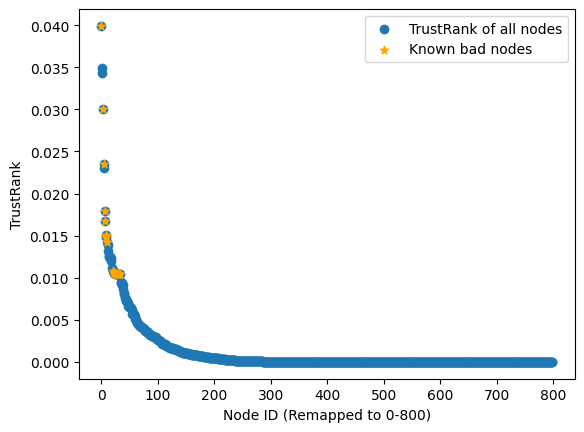

In [ ]:
# sorted original node names according to TrustRank
import matplotlib.pyplot as plt

d = OrderedDict(zip(nodes, node_ranks.A1))

res = list(OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True)))

ub = max(node_ranks.A1)
mapping = dict(zip(res, np.arange(len(res))))
mapping2 = sorted(node_ranks.A1, reverse=True)
mapping3 = [mapping[i] for i in bad_nodes]

plt.scatter(np.arange(len(res)), sorted(node_ranks.A1, reverse=True), label="TrustRank of all nodes")
plt.scatter([mapping[i] for i in bad_nodes], [mapping2[i] for i in mapping3], marker="*", color="orange", label="Known bad nodes")
plt.xlabel("Node ID (Remapped to 0-800)")
plt.ylabel("TrustRank")
plt.legend()
plt.show()

From the plot above we can see that the majority of the ground-truth bad nodes have a higher scores. This shows that the algorithm has worked as intended.

# Histogram

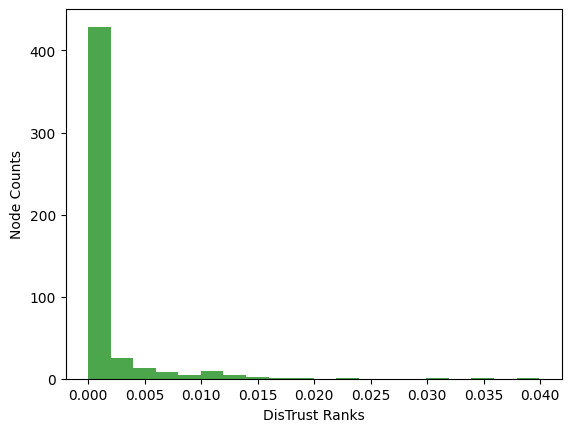

In [ ]:
# histogram of all the node ranks
import matplotlib.pyplot as plt

d = OrderedDict(zip(nodes, node_ranks.A1))

res = list(OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True)))

ub = max(node_ranks.A1)
mapping = dict(zip(res, np.arange(len(res))))
mapping2 = sorted(node_ranks.A1, reverse=True)
mapping3 = [mapping[i] for i in bad_nodes]


plt.hist(node_ranks.A1, 20,
                      density = 1,
                      color ='green',
                      alpha = 0.7)

plt.xlabel("DisTrust Ranks")
plt.ylabel("Node Counts")
plt.show()

The above plot shows that most of the nodes have ranks between 0.00 and 0.01 while a few nodes have higher ranks indicating that the majority of the nodes are good nodes excluding a specific few.

# Iterationwise TrustRank

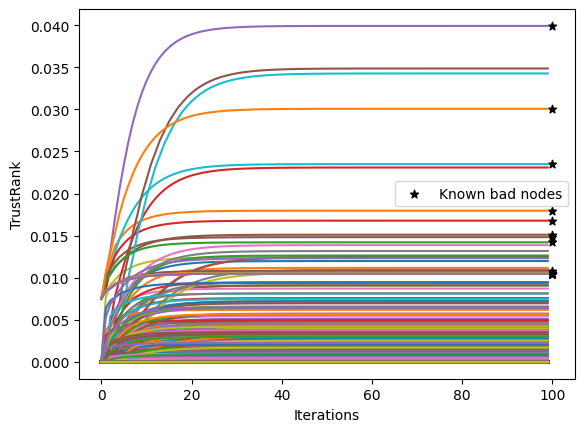

In [ ]:
y = [i.values_iterations for i in p.vertices]
bad_values = [node_ranks.A1[i] for i in bad_nodes]
for i in y:
  plt.plot(np.arange(len(i)), i)
plt.scatter([len(i)]*len(bad_values), bad_values, marker="*", color="black", label="Known bad nodes")
plt.xlabel("Iterations")
plt.ylabel("TrustRank")
plt.legend()
plt.show()

The above plot shows the iteration-wise TrustRank of each nodes and also highlights the bad nodes. We can again observe that most of bad nodes of high rank similar to what we saw in the plot earlier. But we can also notice that there are some nodes which have a much higher score than the bad nodes. These are the predicted bad nodes and the authorities should start with probing these iron dealers for fraud.

In [ ]:
# Ensure final_scores exists before visualization
if 'final_scores' not in locals():
    final_scores = dict(zip(nodes, node_ranks.A1))  # Extract TrustRank scores correctly



# Heatmap

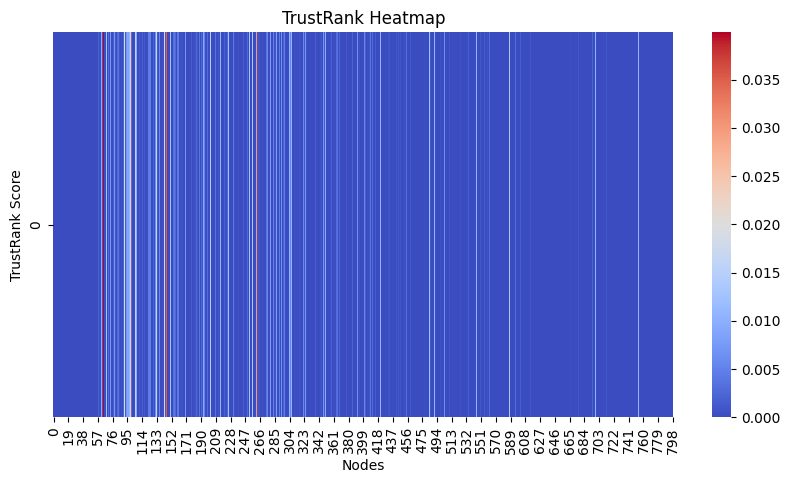

In [ ]:
# Visualization: TrustRank Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(np.array(list(final_scores.values())).reshape(1, -1), cmap="coolwarm", annot=False, cbar=True)
plt.xlabel("Nodes")
plt.ylabel("TrustRank Score")
plt.title("TrustRank Heatmap")
plt.show()


The above plot shows, most nodes have low TrustRank scores, as evidenced by the dark blue color.
Few nodes show high TrustRank scores (lighter streaks), likely representing potential fraudulent accounts.
It is sparse, implying fraudulent accounts are widely separated from the normal users.
The heatmap visually confirms that TrustRank effectively isolates high-risk nodes for further investigation.

# Violin plot

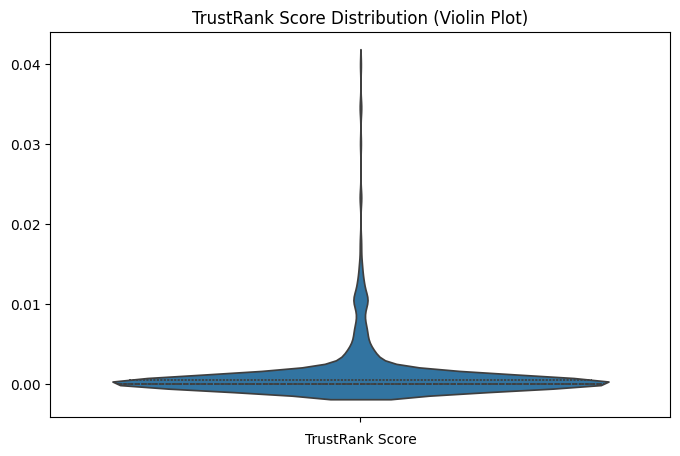

In [ ]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=list(final_scores.values()), inner="quartile")
plt.xlabel("TrustRank Score")
plt.title("TrustRank Score Distribution (Violin Plot)")
plt.show()


The above plot shows that most users have very low TrustRank scores, indicating a majority of trustworthy accounts.
A few anomalies with high scores are a precursor to fraudulent nodes.
The distribution is right-skewed, which implies that fraudulent accounts are well-separated from normal users.
The long upper tail indicates that there are a few high-risk nodes that need further investigation.